# Лабораторная работа №8: Проведение исследований моделями обнаружения и распознавания объектов

В данной работе используется датасет Welding Defect Object Detection: https://www.kaggle.com/datasets/sukmaadhiwijaya/welding-defect-object-detection. Выбор данного датасета обусловлен его практической значимостью для автоматизации контроля качества сварных соединений, раннего выявления дефектов и повышения безопасности промышленных конструкций.

Для оценки качества моделей выбраны следующие метрики:

- **mAP** – учитывает как точность локализации, так и правильность классификации дефектов.
- **IoU** – показывает, насколько точно модель локализует объекты

Загрузим датасет с Kaggle

In [ ]:
import kagglehub

path = kagglehub.dataset_download("sukmaadhiwijaya/welding-defect-object-detection")

100%|██████████| 152M/152M [00:04<00:00, 37.5MB/s]

Extracting files...


Установим необходимые библиотеки

In [ ]:
!pip install ultralytics

import os
import shutil
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import Image, display
import pandas as pd
import seaborn as sns
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

Посмотрим на несколько случайных изображений из датасета

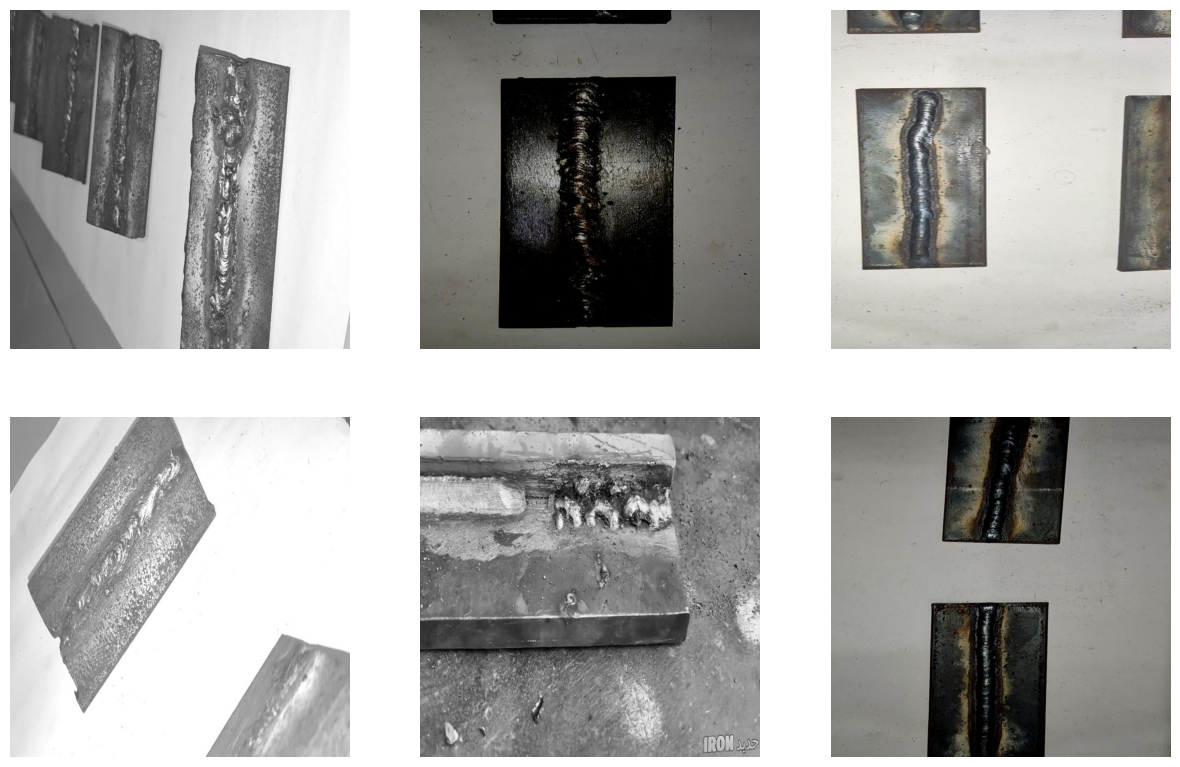

In [ ]:
def display_images(image_dir, num_images=6):
    images = os.listdir(image_dir)
    sample_images = random.sample(images, num_images)
    plt.figure(figsize=(15, 15))
    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.show()

path = os.path.join(path, 'The Welding Defect Dataset/The Welding Defect Dataset')
display_images(os.path.join(path, 'train/images'))

Проанализируем распределение классов

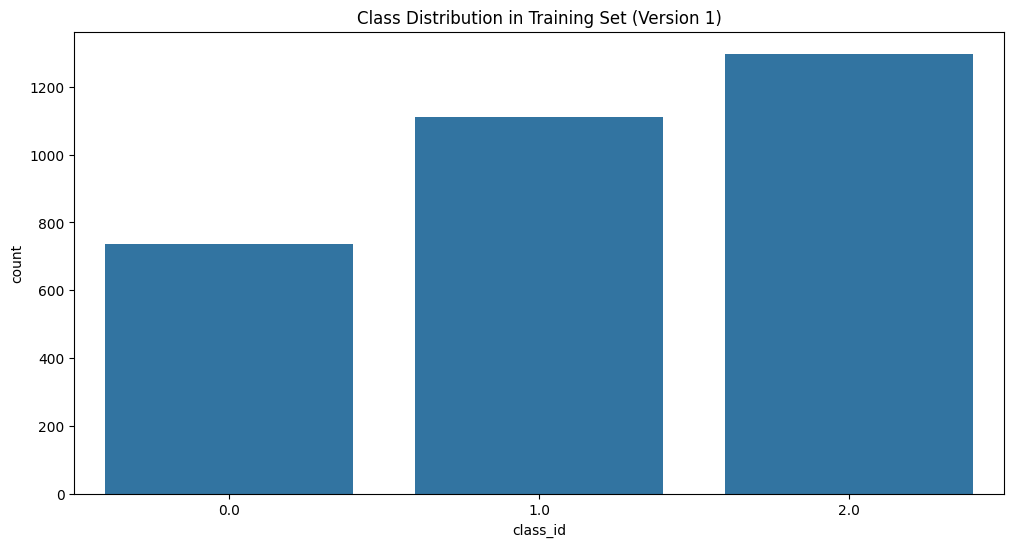

In [ ]:
def load_labels(label_dir):
    label_files = os.listdir(label_dir)
    data = []
    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                data.append([label_file, class_id, x_center, y_center, width, height])
    df = pd.DataFrame(data, columns=['file', 'class_id', 'x_center', 'y_center', 'width', 'height'])
    return df

train_labels = load_labels(os.path.join(path, 'train/labels'))
plt.figure(figsize=(12, 6))
sns.countplot(data=train_labels, x='class_id')
plt.title('Class Distribution in Training Set (Version 1)')
plt.show()

Обучим модель YOLOv11 на базовом наборе гиперпараметров

In [ ]:
model = YOLO("yolo11n.pt")

data_path = path+'/data.yaml'
baseline_results = model.train(
    data=data_path,
    epochs=50,
    imgsz=640,
    batch=16
)

100%|██████████| 5.35M/5.35M [00:00<00:00, 158MB/s]


Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sav

100%|██████████| 755k/755k [00:00<00:00, 39.4MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    431257  ultralytics.nn.modules.head.Detect           [3, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,425 parameters, 2,590,409 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 29.9±17.1 MB/s, size: 50.2 KB)


train: Scanning /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/train/labels... 839 images, 0 backgrounds, 0 corrupt: 100%|██████████| 839/839 [00:01<00:00, 559.68it/s]


train: New cache created: /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 27.0±15.7 MB/s, size: 55.6 KB)


val: Scanning /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/valid/labels... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<00:00, 677.58it/s]

val: New cache created: /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.41G      2.065      3.349      1.735         26        640: 100%|██████████| 53/53 [00:16<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]

                   all        176        573    0.00777      0.708      0.151     0.0591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.8G      1.907      2.663      1.585         58        640: 100%|██████████| 53/53 [00:14<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


                   all        176        573      0.145      0.323      0.154     0.0676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.82G      1.923      2.567      1.598         27        640: 100%|██████████| 53/53 [00:14<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.94it/s]

                   all        176        573      0.323      0.347      0.236      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.83G      1.913      2.528        1.6         44        640: 100%|██████████| 53/53 [00:14<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        176        573      0.241      0.252      0.181     0.0799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.85G      1.865      2.435      1.575         41        640: 100%|██████████| 53/53 [00:15<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]

                   all        176        573      0.214      0.322      0.203     0.0873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.85G       1.83       2.32       1.55         31        640: 100%|██████████| 53/53 [00:15<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]

                   all        176        573      0.271      0.403      0.246      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.88G        1.8      2.275      1.524         44        640: 100%|██████████| 53/53 [00:14<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]

                   all        176        573      0.232      0.422      0.233      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.89G      1.793      2.251      1.534         36        640: 100%|██████████| 53/53 [00:14<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]

                   all        176        573      0.263      0.357      0.233      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.91G      1.754      2.157        1.5         33        640: 100%|██████████| 53/53 [00:14<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.86it/s]

                   all        176        573      0.434      0.388      0.292      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.91G       1.75      2.148      1.504         32        640: 100%|██████████| 53/53 [00:14<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.82it/s]

                   all        176        573      0.279        0.4      0.258      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.94G      1.721       2.08      1.482         44        640: 100%|██████████| 53/53 [00:15<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        176        573      0.359      0.434      0.333       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.95G      1.707       2.01      1.465         53        640: 100%|██████████| 53/53 [00:15<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.06it/s]


                   all        176        573      0.227      0.388      0.285      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.97G      1.698      2.001      1.452         48        640: 100%|██████████| 53/53 [00:15<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]

                   all        176        573      0.427      0.461      0.364      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.97G      1.678      1.948      1.444         48        640: 100%|██████████| 53/53 [00:16<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]

                   all        176        573      0.374       0.43      0.362      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.99G      1.617      1.911      1.418         23        640: 100%|██████████| 53/53 [00:14<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]

                   all        176        573      0.389       0.43      0.341       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.01G      1.635      1.903      1.416         30        640: 100%|██████████| 53/53 [00:14<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.08it/s]

                   all        176        573        0.4      0.493      0.367      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.03G      1.639      1.862      1.428         58        640: 100%|██████████| 53/53 [00:15<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.08it/s]

                   all        176        573      0.486      0.446      0.406      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.03G      1.618      1.867      1.408         34        640: 100%|██████████| 53/53 [00:15<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.06it/s]

                   all        176        573      0.491      0.504       0.42      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.05G      1.612      1.809      1.401         58        640: 100%|██████████| 53/53 [00:14<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.88it/s]

                   all        176        573      0.401       0.49      0.384      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.07G      1.598      1.791      1.393         49        640: 100%|██████████| 53/53 [00:15<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]


                   all        176        573      0.489       0.54      0.426      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.08G      1.568      1.784      1.382         56        640: 100%|██████████| 53/53 [00:14<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.96it/s]

                   all        176        573        0.4      0.531      0.425      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.09G       1.57      1.729       1.35         34        640: 100%|██████████| 53/53 [00:14<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]

                   all        176        573      0.364      0.506      0.396      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.11G      1.542      1.711      1.359         33        640: 100%|██████████| 53/53 [00:14<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        176        573      0.443        0.5      0.421      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.13G      1.546      1.714      1.366         52        640: 100%|██████████| 53/53 [00:14<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        176        573       0.44      0.552      0.457      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.14G       1.49      1.635      1.323         40        640: 100%|██████████| 53/53 [00:14<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.17it/s]

                   all        176        573      0.458       0.55      0.465       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.15G      1.506      1.666       1.35         57        640: 100%|██████████| 53/53 [00:14<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.30it/s]

                   all        176        573      0.424      0.541      0.451      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.17G      1.506      1.627      1.316         52        640: 100%|██████████| 53/53 [00:15<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.06it/s]

                   all        176        573      0.464      0.564      0.478      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.19G      1.501      1.614      1.347         45        640: 100%|██████████| 53/53 [00:14<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.06it/s]

                   all        176        573      0.509      0.545        0.5       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       3.2G      1.484      1.613      1.327         38        640: 100%|██████████| 53/53 [00:14<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.07it/s]

                   all        176        573      0.526      0.499      0.514      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.21G      1.461      1.593      1.319         33        640: 100%|██████████| 53/53 [00:14<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all        176        573      0.451      0.516      0.475      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.23G      1.443      1.563      1.299         59        640: 100%|██████████| 53/53 [00:14<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.24it/s]

                   all        176        573      0.517      0.532      0.504      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.25G      1.435      1.553      1.297         34        640: 100%|██████████| 53/53 [00:14<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]

                   all        176        573      0.516       0.54      0.518      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.26G      1.463       1.55      1.306         29        640: 100%|██████████| 53/53 [00:14<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.35it/s]

                   all        176        573      0.485      0.584      0.499      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.27G       1.43      1.501      1.288         26        640: 100%|██████████| 53/53 [00:15<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]

                   all        176        573       0.49      0.535      0.505      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.29G      1.428      1.473      1.282         42        640: 100%|██████████| 53/53 [00:14<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.08it/s]

                   all        176        573      0.497      0.592      0.532        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.31G      1.402       1.48      1.284         45        640: 100%|██████████| 53/53 [00:14<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.18it/s]

                   all        176        573      0.477      0.584      0.524      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.32G      1.412      1.453      1.276         46        640: 100%|██████████| 53/53 [00:14<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


                   all        176        573      0.466      0.609      0.524      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.33G      1.399      1.438      1.274         32        640: 100%|██████████| 53/53 [00:14<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]

                   all        176        573      0.475       0.59      0.531      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.35G      1.387      1.432      1.263         52        640: 100%|██████████| 53/53 [00:14<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.22it/s]

                   all        176        573      0.533      0.536      0.522      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.37G      1.376      1.405      1.257         49        640: 100%|██████████| 53/53 [00:14<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.04it/s]

                   all        176        573      0.489      0.612      0.538       0.31


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.38G      1.337      1.378      1.303         21        640: 100%|██████████| 53/53 [00:16<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.99it/s]

                   all        176        573      0.529      0.555      0.527      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.38G      1.305      1.343      1.278         38        640: 100%|██████████| 53/53 [00:14<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.28it/s]

                   all        176        573      0.533      0.605      0.554      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.41G      1.289      1.311      1.275         19        640: 100%|██████████| 53/53 [00:13<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]

                   all        176        573      0.546      0.579      0.565      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.42G      1.269      1.268       1.26         27        640: 100%|██████████| 53/53 [00:13<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        176        573      0.577      0.593      0.574       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.44G      1.252      1.229      1.251         30        640: 100%|██████████| 53/53 [00:13<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.04it/s]

                   all        176        573      0.531      0.607       0.57      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.45G       1.24      1.227      1.254         20        640: 100%|██████████| 53/53 [00:13<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.45it/s]

                   all        176        573      0.594      0.599      0.567      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.47G      1.216       1.19      1.241         25        640: 100%|██████████| 53/53 [00:13<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.34it/s]

                   all        176        573      0.539      0.607      0.564      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.48G       1.23      1.182       1.24         28        640: 100%|██████████| 53/53 [00:13<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all        176        573      0.579      0.584      0.573      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       3.5G      1.185      1.159      1.219         25        640: 100%|██████████| 53/53 [00:14<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.39it/s]

                   all        176        573       0.55      0.623      0.585      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.51G      1.199      1.167       1.23         18        640: 100%|██████████| 53/53 [00:13<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]

                   all        176        573      0.595      0.585      0.584      0.346



50 epochs completed in 0.234 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]


                   all        176        573      0.596      0.582      0.583      0.345
              Bad Weld         87        127      0.604      0.732       0.67      0.428
             Good Weld        119        253      0.678      0.723      0.722       0.46
                Defect         90        193      0.505       0.29      0.358      0.148
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/train


Оценим результат обучения

In [ ]:
results = model.val(data=data_path, imgsz=640)

box_metrics = results.box

print("Mean Precision: ", box_metrics.mp)
print("Mean Recall: ", box_metrics.mr)
print("mAP@0.5: ", box_metrics.map50)
print("mAP@0.5-0.95: ", box_metrics.map)

Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 703.3±111.3 MB/s, size: 38.9 KB)


val: Scanning /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/valid/labels.cache... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.04it/s]


                   all        176        573      0.595      0.585      0.584      0.345
              Bad Weld         87        127      0.601      0.735      0.671      0.431
             Good Weld        119        253      0.675      0.723      0.721      0.458
                Defect         90        193      0.509      0.296      0.359      0.147
Speed: 1.8ms preprocess, 6.2ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train2
Mean Precision:  0.5951719789839022
Mean Recall:  0.5846932963820564
mAP@0.5:  0.5835867640669189
mAP@0.5-0.95:  0.345316300878403


Посмотрим на работу обученной модели


image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/test/images/bad_weld_vid89_jpeg_jpg.rf.cdeeae57ff588da1b969bfd75c2a7747.jpg: 640x640 1 Bad Weld, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


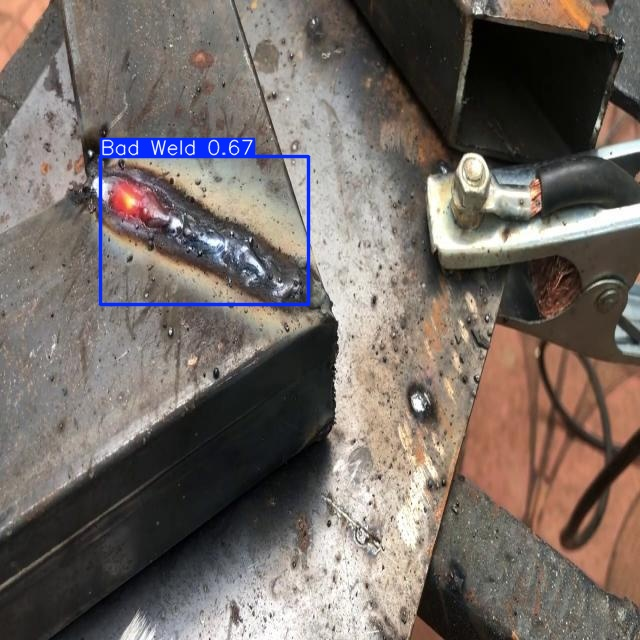


image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/test/images/SampleV2_1_mp4-97_jpg.rf.1cbd06413c3d08495ffce915e0d8bd94.jpg: 640x640 3 Bad Welds, 1 Defect, 11.7ms
Speed: 4.2ms preprocess, 11.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


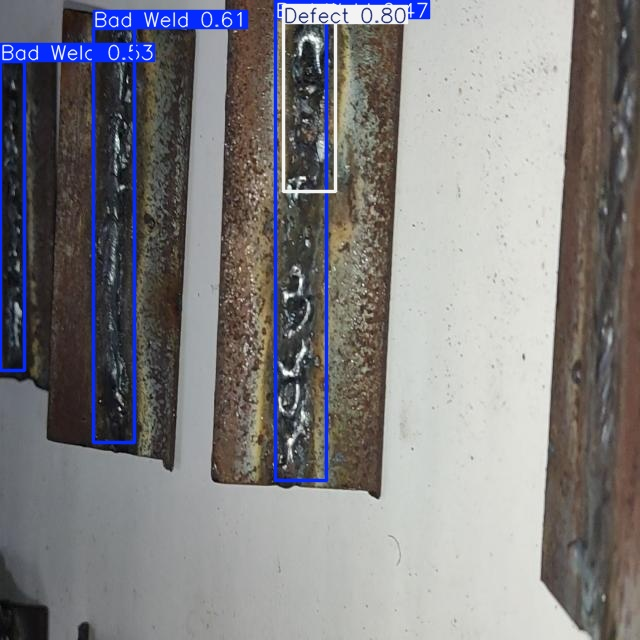


image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/test/images/Screenshot-2022-12-05-223445_jpeg_jpg.rf.e35a047d0ee08846662cb19b302fb1a7.jpg: 640x640 1 Bad Weld, 20 Defects, 11.5ms
Speed: 2.4ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


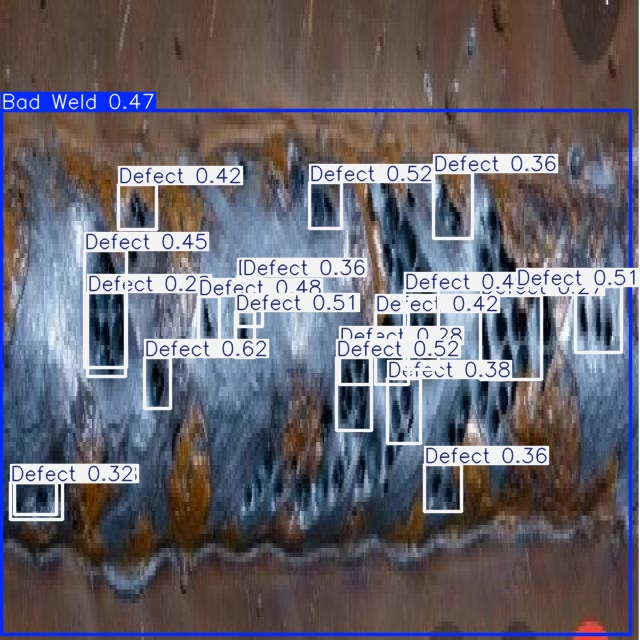

In [ ]:
def display_results(model, img_dir, num_images=3):
    images = os.listdir(img_dir)
    sample_images = random.sample(images, num_images)
    save_dir = 'runs/detect/exp'
    os.makedirs(save_dir, exist_ok=True)

    for image_name in sample_images:
        image_path = os.path.join(img_dir, image_name)
        results = model(image_path)
        for result in results:
            result.plot(save=True, filename=os.path.join(save_dir, os.path.basename(result.path)))
            result_image_path = os.path.join(save_dir, os.path.basename(result.path))
            display(Image(filename=result_image_path))

display_results(model, os.path.join(path, 'test/images'))

### Улучшение бейзлайна

Обучим модель YOLOv11 с расширенным набором гиперпараметров, включающим продвинутую аугментацию (Mosaic, MixUp, цветовые и геометрические искажения) и оптимизацию (повышенный lr0, warmup, регуляризация)

In [ ]:
model = YOLO("yolo11n.pt")

model.train(
    data=data_path,
    epochs=50,
    imgsz=640,
    batch=16,
    lr0=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    box=0.05,
    cls=0.5,
    iou=0.2,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    translate=0.1,
    scale=0.5,
    mosaic=1.0,
    mixup=0.5
  )

Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.2, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

train: Scanning /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/train/labels.cache... 839 images, 0 backgrounds, 0 corrupt: 100%|██████████| 839/839 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 477.7±298.9 MB/s, size: 55.6 KB)


val: Scanning /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/valid/labels.cache... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.76G    0.01525      3.285      1.924         57        640: 100%|██████████| 53/53 [00:20<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        176        573      0.527     0.0447     0.0948     0.0336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.92G    0.01421      2.734      1.773         74        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

                   all        176        573      0.339      0.379      0.223     0.0841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.92G    0.01386      2.612      1.751         51        640: 100%|██████████| 53/53 [00:19<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

                   all        176        573      0.296      0.375       0.23     0.0944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.92G    0.01363      2.523      1.704         74        640: 100%|██████████| 53/53 [00:18<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.01it/s]

                   all        176        573      0.305      0.359      0.246     0.0991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.92G    0.01329      2.404      1.678         61        640: 100%|██████████| 53/53 [00:18<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

                   all        176        573      0.334      0.484      0.281      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.92G    0.01323      2.378      1.674         82        640: 100%|██████████| 53/53 [00:18<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]

                   all        176        573       0.33      0.479      0.275      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.92G    0.01299      2.327      1.658         69        640: 100%|██████████| 53/53 [00:18<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

                   all        176        573      0.389      0.531      0.348       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.92G    0.01273      2.262      1.648         39        640: 100%|██████████| 53/53 [00:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]

                   all        176        573      0.352      0.509      0.366      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.92G     0.0127      2.231      1.634         49        640: 100%|██████████| 53/53 [00:18<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        176        573      0.356      0.488       0.32      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.92G    0.01261      2.179      1.611         80        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

                   all        176        573      0.453      0.425      0.365      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.92G    0.01249      2.162      1.603         27        640: 100%|██████████| 53/53 [00:19<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]

                   all        176        573      0.414      0.466      0.352      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.92G    0.01237      2.134      1.603         55        640: 100%|██████████| 53/53 [00:17<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all        176        573      0.474      0.433      0.355      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.92G    0.01224      2.071      1.582         99        640: 100%|██████████| 53/53 [00:19<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

                   all        176        573      0.434      0.531      0.396      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.92G    0.01223      2.068      1.575         71        640: 100%|██████████| 53/53 [00:19<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all        176        573      0.401      0.531      0.384      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.92G    0.01222      2.036       1.57         49        640: 100%|██████████| 53/53 [00:18<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all        176        573      0.441      0.538      0.438      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.92G    0.01214      2.028      1.573         64        640: 100%|██████████| 53/53 [00:19<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all        176        573      0.367       0.53      0.386      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.92G    0.01197      2.007      1.563         41        640: 100%|██████████| 53/53 [00:18<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        176        573      0.441      0.604      0.426       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.92G    0.01196      1.979      1.541        104        640: 100%|██████████| 53/53 [00:18<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.86it/s]

                   all        176        573      0.406      0.521      0.421      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.92G    0.01191      1.958      1.544         98        640: 100%|██████████| 53/53 [00:19<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]

                   all        176        573      0.428      0.472       0.41      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.92G    0.01183      1.939      1.545         46        640: 100%|██████████| 53/53 [00:18<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        176        573      0.484      0.541      0.445      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.92G    0.01187      1.912      1.537         83        640: 100%|██████████| 53/53 [00:18<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.68it/s]

                   all        176        573      0.455      0.505      0.422      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.92G    0.01153      1.861      1.502         44        640: 100%|██████████| 53/53 [00:18<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all        176        573      0.533       0.57      0.489      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.92G     0.0117      1.938      1.533         30        640: 100%|██████████| 53/53 [00:18<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]

                   all        176        573      0.506      0.537       0.48      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.92G    0.01162       1.89      1.515         77        640: 100%|██████████| 53/53 [00:19<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all        176        573      0.437      0.586      0.464      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.92G    0.01135      1.823      1.487         44        640: 100%|██████████| 53/53 [00:18<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all        176        573       0.48      0.574      0.493      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.92G    0.01143      1.835        1.5         65        640: 100%|██████████| 53/53 [00:18<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]

                   all        176        573      0.504      0.562      0.507      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.92G     0.0113      1.801      1.475         67        640: 100%|██████████| 53/53 [00:19<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]

                   all        176        573      0.497      0.597      0.495      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.92G    0.01126      1.786      1.472         58        640: 100%|██████████| 53/53 [00:18<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        176        573      0.526      0.553      0.489      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.92G    0.01136      1.793      1.495         70        640: 100%|██████████| 53/53 [00:18<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all        176        573      0.513      0.552      0.507      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.92G    0.01116       1.77      1.463         72        640: 100%|██████████| 53/53 [00:19<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]

                   all        176        573      0.517      0.593      0.506      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.92G    0.01133      1.788      1.494         81        640: 100%|██████████| 53/53 [00:18<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.18it/s]

                   all        176        573      0.522      0.607      0.525      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.92G    0.01113      1.725      1.462         66        640: 100%|██████████| 53/53 [00:19<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.69it/s]

                   all        176        573      0.569       0.56      0.517       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.92G    0.01115      1.749      1.454         53        640: 100%|██████████| 53/53 [00:18<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        176        573      0.524      0.588      0.503      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.92G      0.011      1.745       1.46         44        640: 100%|██████████| 53/53 [00:18<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        176        573      0.523      0.585      0.537      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.92G    0.01099        1.7      1.444         73        640: 100%|██████████| 53/53 [00:19<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]

                   all        176        573      0.563       0.59      0.545      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.92G    0.01087      1.663      1.436         43        640: 100%|██████████| 53/53 [00:18<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        176        573      0.528      0.613      0.519      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.92G    0.01074      1.631      1.412         83        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        176        573      0.518      0.633       0.54        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.92G    0.01072      1.619      1.421         64        640: 100%|██████████| 53/53 [00:18<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        176        573      0.542       0.62      0.549      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.92G    0.01087      1.681      1.447         39        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.50it/s]

                   all        176        573      0.598      0.598      0.565      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.92G    0.01057      1.613      1.408         88        640: 100%|██████████| 53/53 [00:19<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]

                   all        176        573      0.575      0.633      0.574      0.318


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.92G   0.009644      1.507      1.369         21        640: 100%|██████████| 53/53 [00:15<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

                   all        176        573      0.559      0.615      0.554      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.92G   0.009441      1.413      1.345         38        640: 100%|██████████| 53/53 [00:14<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        176        573      0.519      0.654      0.557      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.92G   0.009328       1.34      1.334         19        640: 100%|██████████| 53/53 [00:13<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.11it/s]

                   all        176        573      0.534      0.647      0.565      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.92G   0.009122      1.299      1.318         27        640: 100%|██████████| 53/53 [00:14<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.53it/s]

                   all        176        573      0.572      0.645      0.575      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.92G   0.009113      1.262      1.314         30        640: 100%|██████████| 53/53 [00:14<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

                   all        176        573      0.571      0.637      0.578      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.92G   0.009024      1.253      1.314         20        640: 100%|██████████| 53/53 [00:14<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        176        573      0.564      0.639      0.584      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.92G    0.00884      1.211      1.289         25        640: 100%|██████████| 53/53 [00:13<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]

                   all        176        573      0.586      0.647      0.604      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.92G   0.008827      1.199      1.288         28        640: 100%|██████████| 53/53 [00:14<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]

                   all        176        573      0.602      0.642        0.6      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.92G   0.008697      1.186      1.275         25        640: 100%|██████████| 53/53 [00:13<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.38it/s]

                   all        176        573      0.574      0.652      0.588      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.92G   0.008762      1.185      1.284         18        640: 100%|██████████| 53/53 [00:14<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        176        573      0.571      0.656      0.591      0.344



50 epochs completed in 0.281 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 5.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


                   all        176        573        0.6      0.646        0.6      0.349
              Bad Weld         87        127       0.58      0.803      0.697      0.438
             Good Weld        119        253      0.684       0.76      0.736      0.462
                Defect         90        193      0.536      0.373      0.366      0.149
Speed: 0.3ms preprocess, 4.0ms inference, 0.0ms loss, 10.6ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x798b33282750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

Оценим результат обучения модели

In [ ]:
results = model.val(data=data_path, imgsz=640)

box_metrics = results.box

print("Mean Precision: ", box_metrics.mp)
print("Mean Recall: ", box_metrics.mr)
print("mAP@0.5: ", box_metrics.map50)
print("mAP@0.5-0.95: ", box_metrics.map)

Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1021.7±425.7 MB/s, size: 38.9 KB)


val: Scanning /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/valid/labels.cache... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]


                   all        176        573        0.6      0.647        0.6      0.348
              Bad Weld         87        127       0.58      0.805      0.698      0.438
             Good Weld        119        253      0.684      0.762      0.735      0.457
                Defect         90        193      0.535      0.373      0.367       0.15
Speed: 4.5ms preprocess, 5.0ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train32
Mean Precision:  0.5996331182909361
Mean Recall:  0.646583254415435
mAP@0.5:  0.6001956589055447
mAP@0.5-0.95:  0.34817691506440085


Посмотрим на работу обученной модели


image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/test/images/bad_weld_vid89_jpeg_jpg.rf.cdeeae57ff588da1b969bfd75c2a7747.jpg: 640x640 1 Bad Weld, 11.4ms
Speed: 2.6ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


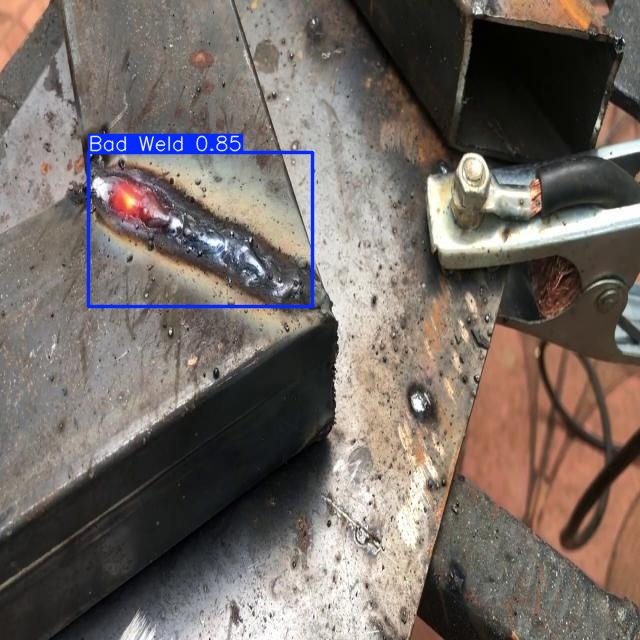


image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/test/images/SampleV2_1_mp4-97_jpg.rf.1cbd06413c3d08495ffce915e0d8bd94.jpg: 640x640 3 Bad Welds, 3 Good Welds, 3 Defects, 11.7ms
Speed: 4.0ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


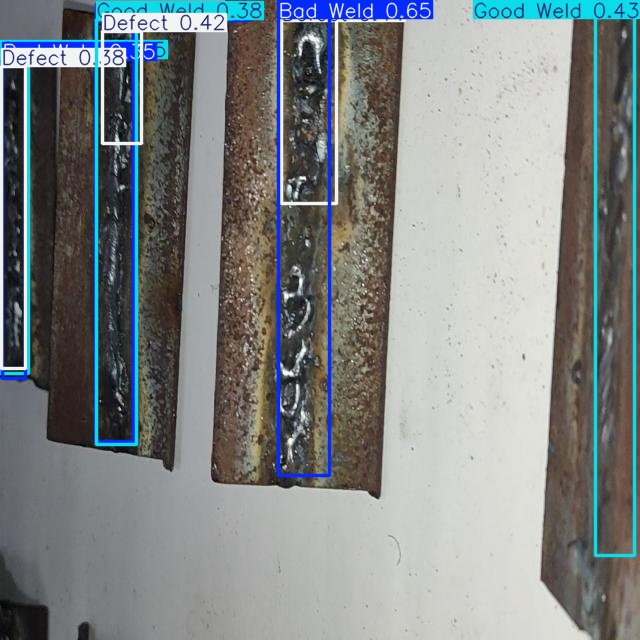


image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/test/images/Screenshot-2022-12-05-223445_jpeg_jpg.rf.e35a047d0ee08846662cb19b302fb1a7.jpg: 640x640 14 Defects, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


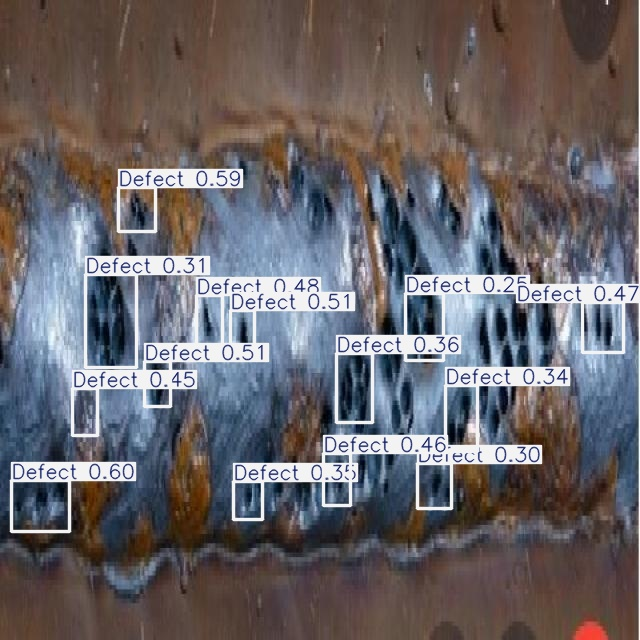

In [ ]:
display_results(model, os.path.join(path, 'test/images'))

## Имплементация алгоритмов

Реализуем пайплайн обучения модели: определим кастомный Dataset, сверточную модели, функцию потерь и цикл обучения с сохранением весов

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class WeldDataset(Dataset):
    def __init__(self, images_dir, labels_dir, S=7, num_classes=3, transform=None):
        self.images_paths = sorted(glob.glob(os.path.join(images_dir, '*.jpg')))
        self.labels_paths = [os.path.join(labels_dir, os.path.basename(f).replace('.jpg', '.txt'))
                             for f in self.images_paths]
        self.S = S
        self.num_classes = num_classes
        self.transform = transform if transform is not None else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        image = Image.open(self.images_paths[idx]).convert('RGB')
        width, height = image.size

        image = self.transform(image)

        target = torch.zeros((self.S, self.S, 5 + self.num_classes), dtype=torch.float)

        label_path = self.labels_paths[idx]
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id, cx, cy, bw, bh = map(float, parts)
                        grid_x = int(cx * self.S)
                        grid_y = int(cy * self.S)
                        cell_x = cx * self.S - grid_x
                        cell_y = cy * self.S - grid_y

                        if target[grid_y, grid_x, 4] == 0:
                            target[grid_y, grid_x, 0:4] = torch.tensor([cell_x, cell_y, bw, bh])
                            target[grid_y, grid_x, 4] = 1.0
                            target[grid_y, grid_x, 5 + int(class_id)] = 1.0
        return image, target

class WeldDetectionModel(nn.Module):
    def __init__(self, S=7, num_classes=3):
        super(WeldDetectionModel, self).__init__()
        self.S = S
        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * S * S, 1024),
            nn.ReLU(),
            nn.Linear(1024, S * S * (5 + num_classes))
        )

    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        x = x.view(-1, self.S, self.S, 5 + self.num_classes)
        return x

class DetectionLoss(nn.Module):
    def __init__(self, S=7, num_classes=3, lambda_coord=5, lambda_noobj=0.5):
        super(DetectionLoss, self).__init__()
        self.S = S
        self.num_classes = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse = nn.MSELoss(reduction='sum')
        self.ce = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, predictions, target):
        batch_size = predictions.size(0)
        total_loss = 0.0

        for b in range(batch_size):
            for i in range(self.S):
                for j in range(self.S):
                    pred_cell = predictions[b, i, j]
                    target_cell = target[b, i, j]

                    if target_cell[4] == 1:
                        coord_loss = self.mse(pred_cell[0:4], target_cell[0:4])
                        conf_loss = self.mse(pred_cell[4], target_cell[4])
                        pred_class = pred_cell[5:]
                        target_class = torch.argmax(target_cell[5:]).unsqueeze(0)
                        class_loss = self.ce(pred_class.unsqueeze(0), target_class)
                        total_loss += self.lambda_coord * coord_loss + conf_loss + class_loss
                    else:
                        noobj_loss = self.lambda_noobj * self.mse(pred_cell[4], target_cell[4])
                        total_loss += noobj_loss
        return total_loss / batch_size

def train_model(model, dataloader, criterion, optimizer, device, num_epochs=20):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    return model

if __name__ == "__main__":
    train_images_dir = path+"/train/images"
    train_labels_dir = path+"/train/labels"

    S = 7
    num_classes = 3
    batch_size = 8
    num_epochs = 20
    learning_rate = 1e-4

    dataset = WeldDataset(train_images_dir, train_labels_dir, S=S, num_classes=num_classes)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    model = WeldDetectionModel(S=S, num_classes=num_classes)
    criterion = DetectionLoss(S=S, num_classes=num_classes)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    trained_model = train_model(model, dataloader, criterion, optimizer, device, num_epochs=num_epochs)

    torch.save(trained_model.state_dict(), "weld_detection_model.pth")

Epoch [1/20], Loss: 11.7381
Epoch [2/20], Loss: 7.6189
Epoch [3/20], Loss: 6.0208
Epoch [4/20], Loss: 5.1450
Epoch [5/20], Loss: 4.5903
Epoch [6/20], Loss: 4.1545
Epoch [7/20], Loss: 3.8789
Epoch [8/20], Loss: 3.6322
Epoch [9/20], Loss: 3.3826
Epoch [10/20], Loss: 3.0540
Epoch [11/20], Loss: 2.7682
Epoch [12/20], Loss: 2.5392
Epoch [13/20], Loss: 2.3775
Epoch [14/20], Loss: 2.1533
Epoch [15/20], Loss: 2.0320
Epoch [16/20], Loss: 1.8598
Epoch [17/20], Loss: 1.6539
Epoch [18/20], Loss: 1.5583
Epoch [19/20], Loss: 1.4784
Epoch [20/20], Loss: 1.4313


Реализуем расчет метрик качества для модели и произведем ее оценку на валидационном датасете

In [ ]:
import torch
import numpy as np
import copy
import glob
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn

def compute_iou(box1, box2):
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    inter_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0.0

def get_boxes_from_output(output, S=7, conf_thresh=0.5):
    boxes = []
    for i in range(S):
        for j in range(S):
            cell = output[i, j]
            conf = cell[4].item()
            if conf > conf_thresh:
                cell_x, cell_y, bw, bh = cell[0].item(), cell[1].item(), cell[2].item(), cell[3].item()
                x_center = (j + cell_x) / S
                y_center = (i + cell_y) / S
                w = bw
                h = bh
                x1 = x_center - w / 2
                y1 = y_center - h / 2
                x2 = x_center + w / 2
                y2 = y_center + h / 2
                predicted_class = int(torch.argmax(cell[5:]).item())
                boxes.append({'box': [x1, y1, x2, y2], 'conf': conf, 'class': predicted_class})
    return boxes

def get_boxes_from_target(target, S=7):
    boxes = []
    for i in range(S):
        for j in range(S):
            cell = target[i, j]
            if cell[4].item() == 1:
                cell_x, cell_y, bw, bh = cell[0].item(), cell[1].item(), cell[2].item(), cell[3].item()
                x_center = (j + cell_x) / S
                y_center = (i + cell_y) / S
                w = bw
                h = bh
                x1 = x_center - w / 2
                y1 = y_center - h / 2
                x2 = x_center + w / 2
                y2 = y_center + h / 2
                gt_class = int(torch.argmax(cell[5:]).item())
                boxes.append({'box': [x1, y1, x2, y2], 'class': gt_class})
    return boxes

def get_class_preds_for_threshold(all_gt, all_pred, iou_thresh, num_classes):
    class_preds = {c: [] for c in range(num_classes)}
    class_gt_counts = {c: 0 for c in range(num_classes)}
    for idx in all_gt.keys():
        gt_boxes = all_gt[idx]
        pred_boxes = all_pred[idx]
        used = [False] * len(gt_boxes)
        for gt in gt_boxes:
            class_gt_counts[gt['class']] += 1
        for pred in pred_boxes:
            c = pred['class']
            best_iou = 0
            best_idx = -1
            for j, gt in enumerate(gt_boxes):
                if gt['class'] == c and not used[j]:
                    iou = compute_iou(pred['box'], gt['box'])
                    if iou > best_iou:
                        best_iou = iou
                        best_idx = j
            if best_iou >= iou_thresh:
                used[best_idx] = True
                pred_copy = copy.deepcopy(pred)
                pred_copy['TP'] = 1
            else:
                pred_copy = copy.deepcopy(pred)
                pred_copy['TP'] = 0
            class_preds[c].append(pred_copy)
    return class_preds, class_gt_counts

def compute_ap(preds, n_gt):
    if n_gt == 0:
        return 0.0
    preds = sorted(preds, key=lambda x: x['conf'], reverse=True)
    tps = np.array([p['TP'] for p in preds])
    fps = np.array([1 - p['TP'] for p in preds])
    cum_tp = np.cumsum(tps)
    cum_fp = np.cumsum(fps)
    precisions = cum_tp / (cum_tp + cum_fp + 1e-6)
    recalls = cum_tp / (n_gt + 1e-6)
    ap = 0.0
    for t in np.linspace(0, 1, 11):
        p_interp = max([p for p, r in zip(precisions, recalls) if r >= t] or [0.0])
        ap += p_interp / 11.0
    return ap

class BoxMetrics:
    def __init__(self, mp, mr, map50, map):
        self.mp = mp
        self.mr = mr
        self.map50 = map50
        self.map = map

def evaluate_model_metrics(model, dataset, S=7, conf_thresh=0.5, base_iou_thresh=0.5, device='cpu'):
    model.to(device)
    model.eval()

    all_gt = {}
    all_pred = {}
    num_images = len(dataset)

    with torch.no_grad():
        for idx in range(num_images):
            image, target = dataset[idx]
            image = image.unsqueeze(0).to(device)
            output = model(image)
            output = output[0].cpu()
            gt_boxes = get_boxes_from_target(target, S=S)
            pred_boxes = get_boxes_from_output(output, S=S, conf_thresh=conf_thresh)
            all_gt[idx] = gt_boxes
            all_pred[idx] = pred_boxes

    num_classes = dataset.num_classes

    class_preds, class_gt_counts = get_class_preds_for_threshold(all_gt, all_pred, base_iou_thresh, num_classes)

    TP_total, FP_total, FN_total = 0, 0, 0
    for c in range(num_classes):
        preds = class_preds[c]
        TP = sum([p['TP'] for p in preds])
        FP = len(preds) - TP
        FN = class_gt_counts[c] - TP
        TP_total += TP
        FP_total += FP
        FN_total += FN
    mp_val = TP_total / (TP_total + FP_total) if (TP_total + FP_total) > 0 else 0.0
    mr_val = TP_total / (TP_total + FN_total) if (TP_total + FN_total) > 0 else 0.0

    ap_per_class = []
    for c in range(num_classes):
        ap = compute_ap(class_preds[c], class_gt_counts[c])
        ap_per_class.append(ap)
    mAP50_val = np.mean(ap_per_class)

    iou_thresholds = np.arange(0.5, 1.0, 0.05)
    ap_list = []
    for thresh in iou_thresholds:
        preds_temp, _ = get_class_preds_for_threshold(all_gt, all_pred, thresh, num_classes)
        ap_per_class_temp = []
        for c in range(num_classes):
            ap = compute_ap(preds_temp[c], class_gt_counts[c])
            ap_per_class_temp.append(ap)
        ap_list.append(np.mean(ap_per_class_temp))
    mAP50_95_val = np.mean(ap_list)

    return BoxMetrics(mp=mp_val, mr=mr_val, map50=mAP50_val, map=mAP50_95_val)

val_images_dir = path+"/valid/images"
val_labels_dir = path+"/valid/labels"

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
val_dataset = WeldDataset(val_images_dir, val_labels_dir, S=7, num_classes=3, transform=val_transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)

In [ ]:
box_metrics = evaluate_model_metrics(trained_model, val_dataset, S=7, conf_thresh=0.5, base_iou_thresh=0.5, device=device)

print("Mean Precision: ", box_metrics.mp)
print("Mean Recall: ", box_metrics.mr)
print("mAP@0.5: ", box_metrics.map50)
print("mAP@0.5-0.95: ", box_metrics.map)

Mean Precision:  0.42299212598425195
Mean Recall:  0.4159362549800797
mAP@0.5:  0.45219087085680537
mAP@0.5-0.95:  0.29038207284704265


### Улучшение бейзлайна

Добавим аугментацию, более глубокую архитектуру модели с остаточными блоками, SmoothL1Loss и scheduler для динамического управления learning rate

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class WeldDataset(nn.Module):
    def __init__(self, images_dir, labels_dir, S=7, num_classes=3, transform=None):
        self.images_paths = sorted(glob.glob(os.path.join(images_dir, '*.jpg')))
        self.labels_paths = [os.path.join(labels_dir, os.path.basename(f).replace('.jpg', '.txt'))
                             for f in self.images_paths]
        self.S = S
        self.num_classes = num_classes
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((448, 448)),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10),
                transforms.ToTensor(),
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        image = Image.open(self.images_paths[idx]).convert('RGB')
        width, height = image.size
        image = self.transform(image)

        target = torch.zeros((self.S, self.S, 5 + self.num_classes), dtype=torch.float)

        label_path = self.labels_paths[idx]
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id, cx, cy, bw, bh = map(float, parts)
                        grid_x = int(cx * self.S)
                        grid_y = int(cy * self.S)
                        cell_x = cx * self.S - grid_x
                        cell_y = cy * self.S - grid_y

                        if target[grid_y, grid_x, 4] == 0:
                            target[grid_y, grid_x, 0:4] = torch.tensor([cell_x, cell_y, bw, bh])
                            target[grid_y, grid_x, 4] = 1.0
                            target[grid_y, grid_x, 5 + int(class_id)] = 1.0
        return image, target

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ImprovedWeldDetectionModel(nn.Module):
    def __init__(self, S=7, num_classes=3):
        super(ImprovedWeldDetectionModel, self).__init__()
        self.S = S
        self.num_classes = num_classes

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.layer4 = ResidualBlock(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((self.S, self.S))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * self.S * self.S, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.S * self.S * (5 + num_classes))
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.fc(x)
        x = x.view(-1, self.S, self.S, 5 + self.num_classes)
        return x


class ImprovedDetectionLoss(nn.Module):
    def __init__(self, S=7, num_classes=3, lambda_coord=5, lambda_noobj=0.5):
        super(ImprovedDetectionLoss, self).__init__()
        self.S = S
        self.num_classes = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.smoothl1 = nn.SmoothL1Loss(reduction='sum')
        self.ce = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, predictions, target):
        batch_size = predictions.size(0)
        total_loss = 0.0

        for b in range(batch_size):
            for i in range(self.S):
                for j in range(self.S):
                    pred_cell = predictions[b, i, j]
                    target_cell = target[b, i, j]
                    if target_cell[4] == 1:
                        coord_loss = self.smoothl1(pred_cell[0:4], target_cell[0:4])
                        conf_loss = self.smoothl1(pred_cell[4], target_cell[4])
                        pred_class = pred_cell[5:].unsqueeze(0)
                        target_class = torch.argmax(target_cell[5:]).unsqueeze(0).long()
                        class_loss = self.ce(pred_class, target_class)
                        total_loss += self.lambda_coord * coord_loss + conf_loss + class_loss
                    else:
                        noobj_loss = self.lambda_noobj * self.smoothl1(pred_cell[4], target_cell[4])
                        total_loss += noobj_loss
        return total_loss / batch_size

def train_improved_model(model, dataloader, criterion, optimizer, scheduler, device, num_epochs=30):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    return model

Обучим модель

In [2]:
  train_images_dir = path + "/train/images"
  train_labels_dir = path + "/train/labels"
  val_images_dir   = path + "/valid/images"
  val_labels_dir   = path + "/valid/labels"

  train_dataset = WeldDataset(train_images_dir, train_labels_dir, S=7, num_classes=3)
  train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)

  val_transform = transforms.Compose([
      transforms.Resize((448, 448)),
      transforms.ToTensor(),
  ])
  val_dataset = WeldDataset(val_images_dir, val_labels_dir, S=7, num_classes=3, transform=val_transform)
  val_dataset.num_classes = 3

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model = ImprovedWeldDetectionModel(S=7, num_classes=3)
  criterion = ImprovedDetectionLoss(S=7, num_classes=3)
  optimizer = optim.Adam(model.parameters(), lr=1e-4)
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

  trained_model = train_improved_model(model, train_loader, criterion, optimizer, scheduler, device, num_epochs=30)
  torch.save(trained_model.state_dict(), "improved_weld_detection_model.pth")

Epoch [1/30], Loss: 8.6957
Epoch [2/30], Loss: 4.6645
Epoch [3/30], Loss: 4.3253
Epoch [4/30], Loss: 4.0783
Epoch [5/30], Loss: 3.7968
Epoch [6/30], Loss: 3.5538
Epoch [7/30], Loss: 3.3355
Epoch [8/30], Loss: 3.1295
Epoch [9/30], Loss: 2.9260
Epoch [10/30], Loss: 2.7078
Epoch [11/30], Loss: 2.5278
Epoch [12/30], Loss: 2.3554
Epoch [13/30], Loss: 2.1765
Epoch [14/30], Loss: 2.0127
Epoch [15/30], Loss: 1.8049
Epoch [16/30], Loss: 1.7125
Epoch [17/30], Loss: 1.5781
Epoch [18/30], Loss: 1.4650
Epoch [19/30], Loss: 1.3411
Epoch [20/30], Loss: 1.1926
Epoch [21/30], Loss: 1.1041
Epoch [22/30], Loss: 1.0021
Epoch [23/30], Loss: 0.9931
Epoch [24/30], Loss: 0.9282
Epoch [25/30], Loss: 0.8924
Epoch [26/30], Loss: 0.8326
Epoch [27/30], Loss: 0.8149
Epoch [28/30], Loss: 0.7636
Epoch [29/30], Loss: 0.7424
Epoch [30/30], Loss: 0.7189


Оценим модель

In [ ]:
box_metrics = evaluate_model_metrics(trained_model, val_dataset, S=7, conf_thresh=0.5, base_iou_thresh=0.5, device=device)

print("Mean Precision: ", box_metrics.mp)
print("Mean Recall: ", box_metrics.mr)
print("mAP@0.5: ", box_metrics.map50)
print("mAP@0.5-0.95: ", box_metrics.map)

Mean Precision:  0.43753351206434316
Mean Recall:  0.5278884462151394
mAP@0.5:  0.5170454468513296
mAP@0.5-0.95:  0.31569917826052535


## Выводы

| Модель                                   | Precision |   Recall  |  mAP\@0.5 | mAP\@0.5‑0.95 |
| ---------------------------------------- | :-------: | :-------: | :-------: | :-----------: |
| YOLOv11n             |   0.595   |   0.585   |   0.584   |     0.345     |
| YOLOv11n (улучшенный бейзлайн)           | **0.600** | **0.647** | **0.600** |   **0.348**   |
| Собственная имплементация                       |   0.423   |   0.416   |   0.452   |     0.290     |
| Собственная имплементация (улучшенный бейзлайн) |   0.438   |   0.528   |   0.517   |     0.316     |

Таким образом, наилучшие результаты показала предобученная YOLOv11n с улучшенным бейзлайном. Улучшение бейзлайна позволило не только повысить точность и полноту, но и обеспечить более высокое среднее значение точности по различным уровням IoU. Собственная имплементация, несмотря на более низкие значения метрик по сравнению с предобученной моделью, продемонстрировала положительную динамику после применения улучшенного бейзлайна. Также все метрики можно еще улучшить, увеличив количество эпох.